In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import enum
import math
import time
from copy import deepcopy
import warnings
import typing as ty
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union, cast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch import Tensor

ModuleType = Union[str, Callable[..., nn.Module]]

def reglu(x : Tensor) -> Tensor:
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim = -1)
    return a * F.relu(b)

def geglu(x : Tensor) -> Tensor:
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim = -1)
    return a * F.gelu(b)

class ReGLU(nn.Module):
    def forward(self, x : Tensor) -> Tensor:
        return reglu(x)
        
class GEGLU(nn.Module):
    def forward(self, x : Tensor) -> Tensor:
        return geglu(x)

def load_model(config: ty.Dict , info_dict : ty.Dict):
    if config["model"] == "ft-transformer":
        return Transformer(
                        d_numerical = int(info_dict["n_num_features"]),
                        categories = None,

                        # Model Architecture
                        n_layers = int(config["n_layers"]),
                        n_heads = int(config["n_heads"]),
                        d_token = int(config["d_token"]),
                        d_ffn_factor = float(config["d_ffn_factor"]),
                        attention_dropout = float(config["attention_dropout"]),
                        ffn_dropout = float(config["attention_dropout"]),
                        residual_dropout = float(config["residual_dropout"]),
                        activation = config["activation"],
                        prenormalization = True,
                        initialization = config["initialization"],
                        
                        # default_Setting
                        token_bias = True,
                        kv_compression = None if int(config["kv_compression"]) == 0 else int(config["kv_compression"]),
                        kv_compression_sharing= None if int(config["kv_compression"]) == 0 else float(config["kv_compression"]),
                        d_out = int(info_dict["n_classes"]) if info_dict["task_type"] == "multiclass" else 1
        )

    elif config["model"] == "resnet":
        return ResNet(
                    d_numerical= int(info_dict["n_num_features"]),
                    categories = None,

                    # ModelA Architecture
                    activation = "relu",
                    d = int(config["d"]),
                    d_embedding = int(config["d_embedding"]),
                    d_hidden_factor = float(config["d_hidden_factor"]), 
                    hidden_dropout = float(config["hidden_dropout"]),
                    n_layers = int(config["n_layers"]),
                    normalization = config["normalization"],
                    residual_dropout = float(config["residual_dropout"]),

                    # default_Setting
                    d_out = int(info_dict["n_classes"]) if info_dict["task_type"] == "multiclass" else 1
        )
    else:
        pass

**FTtrans**

In [2]:
import enum
import math
import time
import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union, cast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch import Tensor
import math
import torch.nn.init as nn_init
import torch
import torch.nn.functional as F

"""
    Model for FTTransformer

    Examples of Test CODE:
        >> Test CODE
            x_num = torch.randn(5, 4)
            X_cat = None
            model = Transformer(d_numerical = 4,
                                categories = get_categories(X_cat), 
                                token_bias = True,
                                kv_compression= None,
                                kv_compression_sharing= None,
                                n_layers = 3,
                                n_heads = 8,
                                d_token = 192,
                                d_ffn_factor= 1.3333333,
                                attention_dropout = 0.2,
                                ffn_dropout = 0.1,
                                residual_dropout = 0.0,
                                activation = "reglu",
                                prenormalization = True,
                                initialization = "kaiming",
                                d_out = 1
                                )
            temp = model(x_num, x_cat = None)
            print(temp)
            print(temp.size())
"""

def get_categories(
    X_cat : ty.Optional[ty.Dict[str, torch.Tensor]]
) -> ty.Optional[ty.List[int]]:
    return (
        None
        if X_cat is None
        else [
            X_cat
        ]
    )

def reglu(x: Tensor) -> Tensor:
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)


def geglu(x: Tensor) -> Tensor:
    a, b = x.chunk(2, dim=-1)
    return a * F.gelu(b)


class ReGLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return reglu(x)


class GEGLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return geglu(x)


def get_activation_fn(name: str) -> ty.Callable[[Tensor], Tensor]:
    return (
        reglu
        if name == 'reglu'
        else geglu
        if name == 'geglu'
        else torch.sigmoid
        if name == 'sigmoid'
        else getattr(F, name)
    )


def get_nonglu_activation_fn(name: str) -> ty.Callable[[Tensor], Tensor]:
    return (
        F.relu
        if name == 'reglu'
        else F.gelu
        if name == 'geglu'
        else get_activation_fn(name)
    )


class Tokenizer(nn.Module):
    category_offsets: ty.Optional[Tensor]

    def __init__(
        self,
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        d_token: int,
        bias: bool,
    ) -> None:
        super().__init__()
        if categories is None:
            d_bias = d_numerical
            self.category_offsets = None
            self.category_embeddings = None
        else:
            d_bias = d_numerical + len(categories)
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_token)
            nn_init.kaiming_uniform_(self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

        # take [CLS] token into account
        self.weight = nn.Parameter(Tensor(d_numerical + 1, d_token))
        self.bias = nn.Parameter(Tensor(d_bias, d_token)) if bias else None
        # The initialization is inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight) + (
            0 if self.category_offsets is None else len(self.category_offsets)
        )

    def forward(self, x_num: Tensor, x_cat: ty.Optional[Tensor]) -> Tensor:
        x_some = x_num if x_cat is None else x_cat
        assert x_some is not None
        x_num = torch.cat(
            [torch.ones(len(x_some), 1, device=x_some.device)]  # [CLS]
            + ([] if x_num is None else [x_num]),
            dim=1,
        )
        x = self.weight[None] * x_num[:, :, None]
        if x_cat is not None:
            x = torch.cat(
                [x, self.category_embeddings(x_cat + self.category_offsets[None])],
                dim=1,
            )
        if self.bias is not None:
            bias = torch.cat(
                [
                    torch.zeros(1, self.bias.shape[1], device=x.device),
                    self.bias,
                ]
            )
            x = x + bias[None]
        return x


class MultiheadAttention(nn.Module):
    def __init__(
        self, d: int, n_heads: int, dropout: float, initialization: str
    ) -> None:
        if n_heads > 1:
            assert d % n_heads == 0
        assert initialization in ['xavier', 'kaiming']

        super().__init__()
        self.W_q = nn.Linear(d, d)
        self.W_k = nn.Linear(d, d)
        self.W_v = nn.Linear(d, d)
        self.W_out = nn.Linear(d, d) if n_heads > 1 else None
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout) if dropout else None

        for m in [self.W_q, self.W_k, self.W_v]:
            if initialization == 'xavier' and (n_heads > 1 or m is not self.W_v):
                # gain is needed since W_qkv is represented with 3 separate layers
                nn_init.xavier_uniform_(m.weight, gain=1 / math.sqrt(2))
            nn_init.zeros_(m.bias)
        if self.W_out is not None:
            nn_init.zeros_(self.W_out.bias)

    def _reshape(self, x: Tensor) -> Tensor:
        batch_size, n_tokens, d = x.shape
        d_head = d // self.n_heads
        return (
            x.reshape(batch_size, n_tokens, self.n_heads, d_head)
            .transpose(1, 2)
            .reshape(batch_size * self.n_heads, n_tokens, d_head)
        )

    def forward(
        self,
        x_q: Tensor,
        x_kv: Tensor,
        key_compression: ty.Optional[nn.Linear],
        value_compression: ty.Optional[nn.Linear],
    ) -> Tensor:
        q, k, v = self.W_q(x_q), self.W_k(x_kv), self.W_v(x_kv)
        for tensor in [q, k, v]:
            assert tensor.shape[-1] % self.n_heads == 0
        if key_compression is not None:
            assert value_compression is not None
            k = key_compression(k.transpose(1, 2)).transpose(1, 2)
            v = value_compression(v.transpose(1, 2)).transpose(1, 2)
        else:
            assert value_compression is None

        batch_size = len(q)
        d_head_key = k.shape[-1] // self.n_heads
        d_head_value = v.shape[-1] // self.n_heads
        n_q_tokens = q.shape[1]

        q = self._reshape(q)
        k = self._reshape(k)
        attention = F.softmax(q @ k.transpose(1, 2) / math.sqrt(d_head_key), dim=-1)
        if self.dropout is not None:
            attention = self.dropout(attention)
        x = attention @ self._reshape(v)
        x = (
            x.reshape(batch_size, self.n_heads, n_q_tokens, d_head_value)
            .transpose(1, 2)
            .reshape(batch_size, n_q_tokens, self.n_heads * d_head_value)
        )
        if self.W_out is not None:
            x = self.W_out(x)
        return x


class Transformer(nn.Module):
    def __init__(
        self,
        *,
        # tokenizer
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        token_bias: bool,
        # transformer
        n_layers: int,
        d_token: int,
        n_heads: int,
        d_ffn_factor: float,
        attention_dropout: float,
        ffn_dropout: float,
        residual_dropout: float,
        activation: str,
        prenormalization: bool,
        initialization: str,
        # linformer
        kv_compression: ty.Optional[float],
        kv_compression_sharing: ty.Optional[str],
        #
        d_out: int,
    ) -> None:
        assert (kv_compression is None) ^ (kv_compression_sharing is not None)

        super().__init__()
        self.tokenizer = Tokenizer(d_numerical, categories, d_token, token_bias)
        n_tokens = self.tokenizer.n_tokens

        def make_kv_compression():
            assert kv_compression
            compression = nn.Linear(
                n_tokens, int(n_tokens * kv_compression), bias=False
            )
            if initialization == 'xavier':
                nn_init.xavier_uniform_(compression.weight)
            return compression

        self.shared_kv_compression = (
            make_kv_compression()
            if kv_compression and kv_compression_sharing == 'layerwise'
            else None
        )

        def make_normalization():
            return nn.LayerNorm(d_token)

        d_hidden = int(d_token * d_ffn_factor)
        self.layers = nn.ModuleList([])
        for layer_idx in range(n_layers):
            layer = nn.ModuleDict(
                {
                    'attention': MultiheadAttention(
                        d_token, n_heads, attention_dropout, initialization
                    ),
                    'linear0': nn.Linear(
                        d_token, d_hidden * (2 if activation.endswith('glu') else 1)
                    ),
                    'linear1': nn.Linear(d_hidden, d_token),
                    'norm1': make_normalization(),
                }
            )
            if not prenormalization or layer_idx:
                layer['norm0'] = make_normalization()
            if kv_compression and self.shared_kv_compression is None:
                layer['key_compression'] = make_kv_compression()
                if kv_compression_sharing == 'headwise':
                    layer['value_compression'] = make_kv_compression()
                else:
                    assert kv_compression_sharing == 'key-value'
            self.layers.append(layer)

        self.activation = get_activation_fn(activation)
        self.last_activation = get_nonglu_activation_fn(activation)
        self.prenormalization = prenormalization
        self.last_normalization = make_normalization() if prenormalization else None
        self.ffn_dropout = ffn_dropout
        self.residual_dropout = residual_dropout
        self.head = nn.Linear(d_token, d_out)

    def _get_kv_compressions(self, layer):
        return (
            (self.shared_kv_compression, self.shared_kv_compression)
            if self.shared_kv_compression is not None
            else (layer['key_compression'], layer['value_compression'])
            if 'key_compression' in layer and 'value_compression' in layer
            else (layer['key_compression'], layer['key_compression'])
            if 'key_compression' in layer
            else (None, None)
        )

    def _start_residual(self, x, layer, norm_idx):
        x_residual = x
        if self.prenormalization:
            norm_key = f'norm{norm_idx}'
            if norm_key in layer:
                x_residual = layer[norm_key](x_residual)
        return x_residual

    def _end_residual(self, x, x_residual, layer, norm_idx):
        if self.residual_dropout:
            x_residual = F.dropout(x_residual, self.residual_dropout, self.training)
        x = x + x_residual
        if not self.prenormalization:
            x = layer[f'norm{norm_idx}'](x)
        return x

    def forward(self, x_num: Tensor, x_cat: ty.Optional[Tensor]) -> Tensor:
        x = self.tokenizer(x_num, x_cat)

        def checkpointed_layer_fn(x, layer_dict, is_last_layer):
    
            layer = layer_dict
    
            x_residual = self._start_residual(x, layer, 0)
            x_residual = layer['attention'](
                (x_residual[:, :1] if is_last_layer else x_residual),
                x_residual,
                *self._get_kv_compressions(layer),
            )
            if is_last_layer:
                x = x[:, : x_residual.shape[1]]
            x = self._end_residual(x, x_residual, layer, 0)
    
            x_residual = self._start_residual(x, layer, 1)
            x_residual = layer['linear0'](x_residual)
            x_residual = self.activation(x_residual)
            if self.ffn_dropout:
                x_residual = F.dropout(x_residual, self.ffn_dropout, self.training)
            x_residual = layer['linear1'](x_residual)
            x = self._end_residual(x, x_residual, layer, 1)
            return x
    
        #  checkpoint
        for layer_idx, layer in enumerate(self.layers):
            is_last_layer = layer_idx + 1 == len(self.layers)
            layer = ty.cast(ty.Dict[str, nn.Module], layer)
            x = checkpoint(checkpointed_layer_fn, x, layer, is_last_layer)
    
        assert x.shape[1] == 1
        x = x[:, 0]
        if self.last_normalization is not None:
            x = self.last_normalization(x)
        x = self.last_activation(x)
        x = self.head(x)
        return x

In [ ]:
import pandas as pd

train_path = "/kaggle/input/optiver-data/processed_train.csv"
test_path = "/kaggle/input/optiver-data/processed_test.csv"

train = pd.read_csv(train_path).head(5000) # use a smaller dataset to train the model normally, or the CUDE memory will be out of memory
test = pd.read_csv(test_path)

In [4]:
X = train.drop(['row_id', 'target', 'time_id'], axis = 1)
y = train['target']
X_test=test.copy()
X_test.drop(['time_id','row_id'], axis=1,inplace=True)

In [5]:
# RMSPE for offline validation
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# RMSE
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# MAE
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# R² Score
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [6]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

nunique = X.nunique()
types = X.dtypes

categorical_columns = []
categorical_dims =  {}

for col in X.columns:
    if  col == 'stock_id':
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        X_test[col] = l_enc.transform(X_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
        


cat_idxs = [ i for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

Trainning FT

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.checkpoint import checkpoint

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# RMSPE metric function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# RMSPE loss function for training
class RMSPELoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2))

# Seed setting function
def seed_everything(seed=42):
    import os, random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Prepare features
cat_columns = ['stock_id']
num_columns = [col for col in X.columns if col not in cat_columns]

X_num = torch.tensor(X[num_columns].values, dtype=torch.float32)
X_cat = torch.tensor(X[cat_columns].values, dtype=torch.long)
y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

X_test_num = torch.tensor(X_test[num_columns].values, dtype=torch.float32)
X_test_cat = torch.tensor(X_test[cat_columns].values, dtype=torch.long)

# FT-Transformer model configuration
model_params = dict(
    d_numerical = X_num.shape[1],
    categories = [X[cat_columns[0]].nunique()],
    token_bias = True,
    n_layers = 3,
    n_heads = 8,
    d_token = 192,
    d_ffn_factor = 1.333,
    attention_dropout = 0.2,
    ffn_dropout = 0.1,
    residual_dropout = 0.0,
    activation = "reglu",
    prenormalization = True,
    initialization = "kaiming",
    kv_compression = None,
    kv_compression_sharing = None,
    d_out = 1
)

# 5-fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros((X.shape[0],))
test_preds = np.zeros(X_test.shape[0])
fold_scores = []
stats = {}

# Training loop
for fold, (train_idx, val_idx) in enumerate(tqdm(kfold.split(X_num), total=5, desc="Cross-validation Folds")):
    print(f"\nTraining Fold {fold + 1}")

    # Initialize model and optimizer
    model = Transformer(**model_params).to(device)
    criterion = RMSPELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Split data
    x_trn_num, x_val_num = X_num[train_idx], X_num[val_idx]
    x_trn_cat, x_val_cat = X_cat[train_idx], X_cat[val_idx]
    y_trn, y_val = y_tensor[train_idx], y_tensor[val_idx]

    x_trn_num, x_val_num = x_trn_num.to(device), x_val_num.to(device)
    x_trn_cat, x_val_cat = x_trn_cat.to(device), x_val_cat.to(device)
    y_trn, y_val = y_trn.to(device), y_val.to(device)

    # DataLoader
    batch_size = 64
    train_dataset = TensorDataset(x_trn_num, x_trn_cat, y_trn)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_loss_history = []
    val_loss_history = []

    # Early stopping setup
    patience = 25
    best_val_loss = np.inf
    early_stop_counter = 0
    best_model_state = None

    for epoch in range(100):
        model.train()
        epoch_loss = 0

        # Mini-batch training with progress bar
        for xb_num, xb_cat, yb in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/100", leave=False):
            xb_num, xb_cat, yb = xb_num.to(device), xb_cat.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb_num, xb_cat)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss_history.append(epoch_loss / len(train_loader))

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_output = model(x_val_num, x_val_cat)
            val_loss = criterion(val_output, y_val).item()
            val_loss_history.append(val_loss)

        # Check for improvement
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        torch.cuda.empty_cache()

    # Save best model and loss history
    stats[f'fold{fold+1}_train_rmspe'] = train_loss_history
    stats[f'fold{fold+1}_val_rmspe'] = val_loss_history
    torch.save(best_model_state, f"ft_transformer_fold{fold+1}.pth")

    # Predict validation and test
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        val_output = model(x_val_num, x_val_cat).cpu().numpy().flatten()
        test_output = model(X_test_num.to(device), X_test_cat.to(device)).cpu().numpy().flatten()

    oof_preds[val_idx] = val_output
    test_preds += test_output / 5

    y_val_np = y[val_idx].values
    fold_scores.append({
        "fold": fold + 1,
        "RMSPE": rmspe(y_val_np, val_output),
        "RMSE": mean_squared_error(y_val_np, val_output, squared=False),
        "MAE": mean_absolute_error(y_val_np, val_output),
        "R2": r2_score(y_val_np, val_output)
    })

    print(f"Fold {fold + 1} Metrics:")
    print(f"RMSPE: {fold_scores[-1]['RMSPE']:.6f}, RMSE: {fold_scores[-1]['RMSE']:.6f}, "
          f"MAE: {fold_scores[-1]['MAE']:.6f}, R2: {fold_scores[-1]['R2']:.4f}")

# Final evaluation across all folds
print("\nFinal OOF Evaluation:")
print(f"RMSPE: {rmspe(y, oof_preds):.6f}")
print(f"RMSE : {mean_squared_error(y, oof_preds):.6f}")
print(f"MAE  : {mean_absolute_error(y, oof_preds):.6f}")
print(f"R2   : {r2_score(y, oof_preds):.4f}")

Using device: cuda


Cross-validation Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Fold 1
self.category_embeddings.weight.shape=torch.Size([2, 192])


Fold 1 | Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 1 | Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1 | Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Early stopping triggered at epoch 55
Fold 1 Metrics:
RMSPE: 0.400869, RMSE: 0.001370, MAE: 0.000951, R2: 0.7508

Training Fold 2
self.category_embeddings.weight.shape=torch.Size([2, 192])


Fold 2 | Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2 | Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 | Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2 Metrics:
RMSPE: 0.234158, RMSE: 0.001275, MAE: 0.000753, R2: 0.7884

Training Fold 3
self.category_embeddings.weight.shape=torch.Size([2, 192])


Fold 3 | Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 3 | Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 | Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3 Metrics:
RMSPE: 0.294287, RMSE: 0.001392, MAE: 0.000928, R2: 0.7586

Training Fold 4
self.category_embeddings.weight.shape=torch.Size([2, 192])


Fold 4 | Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 4 | Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4 | Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Early stopping triggered at epoch 81
Fold 4 Metrics:
RMSPE: 0.322364, RMSE: 0.001441, MAE: 0.001074, R2: 0.7387

Training Fold 5
self.category_embeddings.weight.shape=torch.Size([2, 192])


Fold 5 | Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 5 | Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 | Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5 Metrics:
RMSPE: 0.290152, RMSE: 0.001339, MAE: 0.000937, R2: 0.7588

Final OOF Evaluation:
RMSPE: 0.313126
RMSE : 0.000002
MAE  : 0.000929
R2   : 0.7590


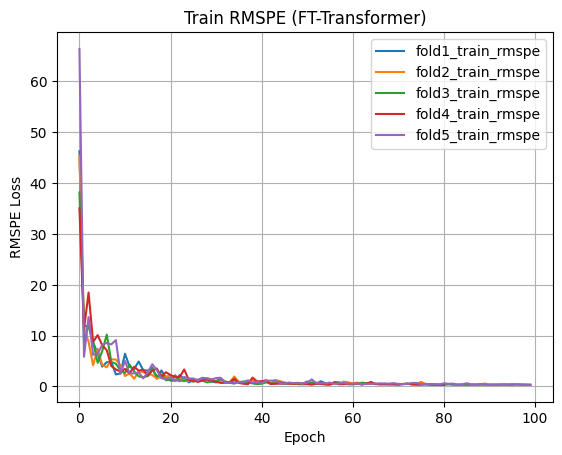

In [8]:
for key in stats:
    if 'train' in key:
        plt.plot(stats[key], label=key)

plt.title('Train RMSPE (FT-Transformer)')
plt.xlabel('Epoch')
plt.ylabel('RMSPE Loss')
plt.legend()
plt.grid(True)
plt.show()

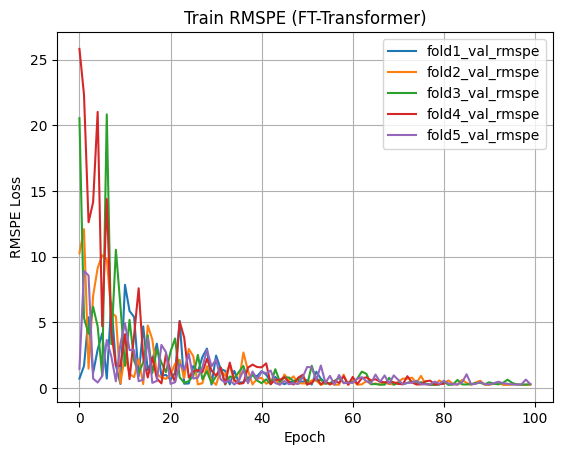

In [9]:
for key in stats:
    if 'val' in key:
        plt.plot(stats[key], label=key)

plt.title('Train RMSPE (FT-Transformer)')
plt.xlabel('Epoch')
plt.ylabel('RMSPE Loss')
plt.legend()
plt.grid(True)
plt.show()